Notebook exploring the non-SFMS component of the best-fit GMMs

In [1]:
import numpy as np 
import corner as DFM
from scipy.stats import multivariate_normal as MNorm

import env
import catalogs as Cats
from fstarforms import fstarforms

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline


------ illustris_inst ------
7000 of 66808 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
1102 galaxies have nonsensical logM* or logSFR values
SFMS is not well defined in the M* bin11.1525-11.3525
SFMS is not well defined in the M* bin11.3525-11.5525


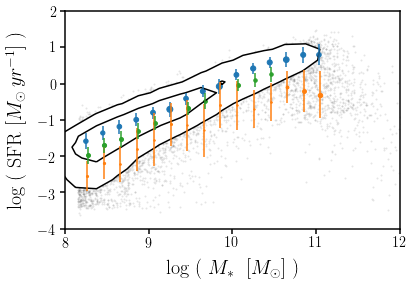


------ illustris_100myr ------
16943 of 66808 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
7678 galaxies have nonsensical logM* or logSFR values
SFMS is not well defined in the M* bin11.1525-11.3525
SFMS is not well defined in the M* bin11.3525-11.5525


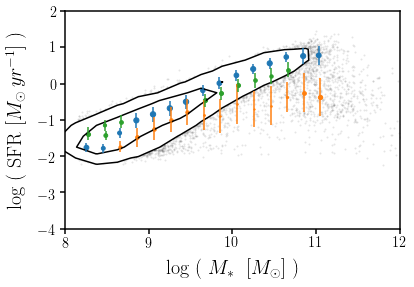


------ eagle_inst ------
10295 of 29810 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
2663 galaxies have nonsensical logM* or logSFR values


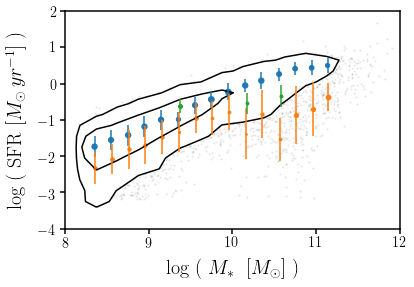


------ eagle_100myr ------
14743 of 29810 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
5942 galaxies have nonsensical logM* or logSFR values


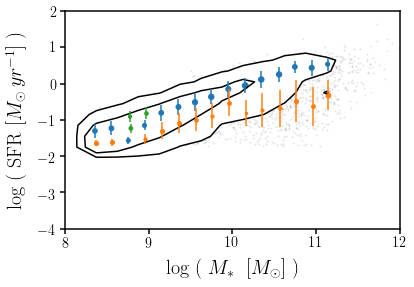


------ mufasa_inst ------
3636 of 7973 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
909 galaxies have nonsensical logM* or logSFR values


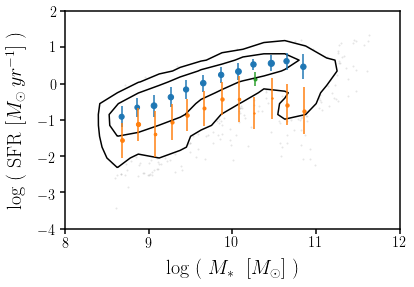


------ mufasa_100myr ------
4811 of 7973 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
1777 galaxies have nonsensical logM* or logSFR values


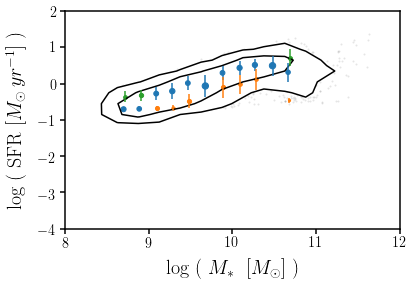


------ scsam_inst ------
30482 of 66090 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
1146 galaxies have nonsensical logM* or logSFR values


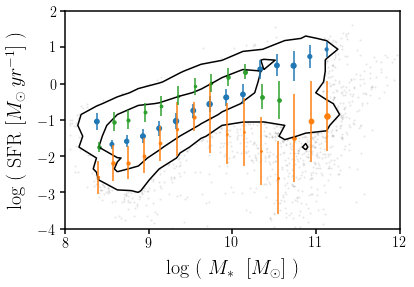


------ scsam_100myr ------
30108 of 66090 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
1087 galaxies have nonsensical logM* or logSFR values


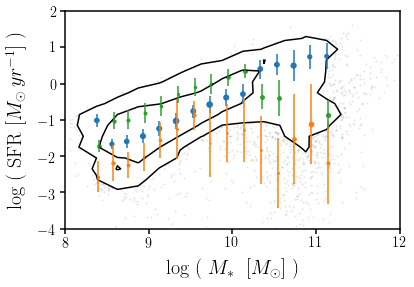

In [7]:
for sim in ['illustris', 'eagle', 'mufasa', 'scsam']:
    for tscale in ['inst', '100myr']:
        Cat = Cats.Catalog()
        _logM, _logSFR, w, censat = Cat.Read(sim+'_'+tscale)
        iscen = (censat == 1)
        logM = _logM[iscen]
        logSFR = _logSFR[iscen]

        fSFMS = fstarforms()
        fit_logm, fit_logsfr = fSFMS.fit(logM, logSFR, method='gaussmix', forTest=True)

        fig = plt.figure()
        sub = fig.add_subplot(111)
        DFM.hist2d(logM, logSFR, color='k', levels=[0.68, 0.95], range=[[7., 12.], [-4., 2.]], 
                   plot_density=False, ax=sub)

        sfms_err, w_sfms = [], []
        for i_m in range(len(fit_logm)): 
            sfms = fSFMS._gmix_means[i_m] == fit_logsfr[i_m]-fit_logm[i_m]
            sfms_err.append(np.sqrt(fSFMS._gmix_covariances[i_m][sfms]))
            w_sfms.append(fSFMS._gmix_weights[i_m][sfms][0])
        sub.errorbar(fit_logm, fit_logsfr, yerr=sfms_err, ms=0, fmt='.C0')
        sub.scatter(fit_logm, fit_logsfr, s=40.*np.array(w_sfms), color='C0')

        for i_m, fitlogm in enumerate(fit_logm): 
            quenched = (range(len(fSFMS._gmix_means[i_m])) == fSFMS._gmix_means[i_m].argmin()) & (fSFMS._gmix_means[i_m] != fit_logsfr[i_m]-fit_logm[i_m])
            transit = (fSFMS._gmix_means[i_m] != fit_logsfr[i_m]-fit_logm[i_m]) & (fSFMS._gmix_means[i_m] != fSFMS._gmix_means[i_m].min())
            if np.sum(quenched) > 0: 
                sub.errorbar([fitlogm+0.01], fSFMS._gmix_means[i_m][quenched]+fitlogm, 
                             yerr=np.sqrt(fSFMS._gmix_covariances[i_m][quenched]), 
                             fmt='.C1', ms=0)#marker='x')
                sub.scatter([fitlogm+0.01], fSFMS._gmix_means[i_m][quenched]+fitlogm, 
                             s=40.*np.array(fSFMS._gmix_weights[i_m][quenched]), color='C1')
            if np.sum(transit) > 0: 
                sub.errorbar([fitlogm + 0.01*(i+2) for i in range(np.sum(transit))], 
                             fSFMS._gmix_means[i_m][transit]+fitlogm, 
                             yerr=np.sqrt(fSFMS._gmix_covariances[i_m][transit]), 
                             ms=0, fmt='.C2')
                sub.scatter([fitlogm + 0.01*(i+2) for i in range(np.sum(transit))], 
                             fSFMS._gmix_means[i_m][transit]+fitlogm, 
                            s=40.*np.array(fSFMS._gmix_weights[i_m][transit]), color='C2')
        #sub.scatter(fit_logm, fit_logsfr, marker='x', color='k')
        sub.set_xlim([8., 12.])
        sub.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
        sub.set_ylim([-4., 2.])
        sub.set_ylabel(r'log ( SFR $[M_\odot \, yr^{-1}]$ )', labelpad=10, fontsize=20)
        plt.show()


------ tinkergroup ------
3 of 12344 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
3 galaxies have nonsensical logM* or logSFR values
SFMS is not well defined in the M* bin11.3000110623-11.5000110623


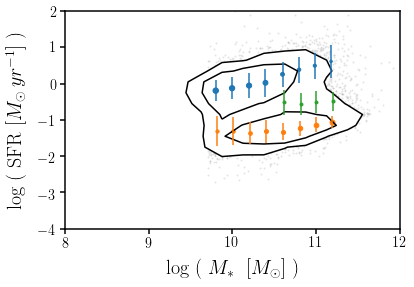


------ nsa_dickey ------
53 of 14998 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
53 galaxies have nonsensical logM* or logSFR values


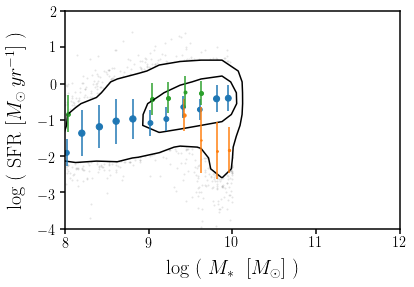

In [6]:
for cat in ['tinkergroup', 'nsa_dickey']:
    Cat = Cats.Catalog()
    _logM, _logSFR, w, censat = Cat.Read(cat)
    iscen = (censat == 1)
    logM = _logM[iscen]
    logSFR = _logSFR[iscen]

    fSFMS = fstarforms()
    fit_logm, fit_logsfr = fSFMS.fit(logM, logSFR, method='gaussmix', forTest=True)

    fig = plt.figure()
    sub = fig.add_subplot(111)
    DFM.hist2d(logM, logSFR, color='k', levels=[0.68, 0.95], range=[[7., 12.], [-4., 2.]], 
               plot_density=False, ax=sub)

    sfms_err, w_sfms = [], []
    for i_m in range(len(fit_logm)): 
        sfms = fSFMS._gmix_means[i_m] == fit_logsfr[i_m]-fit_logm[i_m]
        sfms_err.append(np.sqrt(fSFMS._gmix_covariances[i_m][sfms]))
        w_sfms.append(fSFMS._gmix_weights[i_m][sfms][0])
    sub.errorbar(fit_logm, fit_logsfr, yerr=sfms_err, ms=0, fmt='.C0')
    sub.scatter(fit_logm, fit_logsfr, s=40.*np.array(w_sfms), color='C0')

    for i_m, fitlogm in enumerate(fit_logm): 
        quenched = (range(len(fSFMS._gmix_means[i_m])) == fSFMS._gmix_means[i_m].argmin()) & (fSFMS._gmix_means[i_m] != fit_logsfr[i_m]-fit_logm[i_m])
        transit = (fSFMS._gmix_means[i_m] != fit_logsfr[i_m]-fit_logm[i_m]) & (fSFMS._gmix_means[i_m] != fSFMS._gmix_means[i_m].min())
        if np.sum(quenched) > 0: 
            sub.errorbar([fitlogm+0.01], fSFMS._gmix_means[i_m][quenched]+fitlogm, 
                         yerr=np.sqrt(fSFMS._gmix_covariances[i_m][quenched]), 
                         fmt='.C1', ms=0)#marker='x')
            sub.scatter([fitlogm+0.01], fSFMS._gmix_means[i_m][quenched]+fitlogm, 
                         s=40.*np.array(fSFMS._gmix_weights[i_m][quenched]), color='C1')
        if np.sum(transit) > 0: 
            sub.errorbar([fitlogm + 0.01*(i+2) for i in range(np.sum(transit))], 
                         fSFMS._gmix_means[i_m][transit]+fitlogm, 
                         yerr=np.sqrt(fSFMS._gmix_covariances[i_m][transit]), 
                         ms=0, fmt='.C2')
            sub.scatter([fitlogm + 0.01*(i+2) for i in range(np.sum(transit))], 
                         fSFMS._gmix_means[i_m][transit]+fitlogm, 
                        s=40.*np.array(fSFMS._gmix_weights[i_m][transit]), color='C2')
    #sub.scatter(fit_logm, fit_logsfr, marker='x', color='k')
    sub.set_xlim([8., 12.])
    sub.set_xlabel(r'log ( $M_* \;\;[M_\odot]$ )', labelpad=10, fontsize=20)
    sub.set_ylim([-4., 2.])
    sub.set_ylabel(r'log ( SFR $[M_\odot \, yr^{-1}]$ )', labelpad=10, fontsize=20)
    plt.show()